In [1]:
import pickle
import pandas as pd
from collections import namedtuple
import mxnet.ndarray as nd
from mxnet.gluon import HybridBlock, nn
from mxnet.gluon.nn import Activation

In [98]:
# 加载 gene entry 对对应数据
def load_gene_to_entry():
    hsa2symbol = pd.read_csv('data/hsa2symbol.csv', sep=',', header=None)
    hsa2symbol = hsa2symbol.set_index(hsa2symbol[1])
    
    # gene_to_index
    genelist =  pd.read_csv('data/symbol_nodes.csv',sep='\t', header=None)
    genelist_order = sorted(list(genelist[0]))
    gene_to_index = dict(zip(genelist_order, list(range(len(genelist_order)))))
    with open('data/pathway2enzyme.pickle.txt','rb') as file:
        enzymeDict_load = pickle.load(file)
    res = [i for path in enzymeDict_load.keys() for i in enzymeDict_load[path]['entry2gene']]
    res = pd.DataFrame(res)
    for i in range(res.shape[0]):
        gl = [hsa2symbol.at[h,0] for h in res.iat[i,1].split(' ') if h in hsa2symbol.index]
        res.iat[i,1] = ' '.join(gl)
    res = res.loc[-(res[1]=='')]
    #entrylist, 
    entrygene = res.loc[-res[1].duplicated(), 1]
    entrygene = entrygene.reset_index(drop=True).reset_index()
    geneset2entryID = dict(zip(entrygene[1], entrygene['index']))
    res['entryID'] = res[1].map(geneset2entryID).apply(lambda x: 'entry'+str(x))
    entrylist = sorted(list(set(res['entryID'])), key=lambda x:int(x[5:]))
    # entry_to_gene
    entry_to_gene = dict(zip(res['entryID'], res[1]))
    
    # pathwaylist
    pathway_nodes = pd.read_csv('data/pathway_nodes.csv', header=None)
    pathwaylist = sorted(list(pathway_nodes[0]))
    # pathway_to_entry
    res['pathwayID'] = res[0].apply(lambda x: x.split('_')[0])
    pathway_to_entry = dict(res.groupby('pathwayID')['entryID'].apply(lambda x: ' '.join(x)))
    # entry_to_index
    entry_to_index = dict(zip(entrylist, list(range(len(entrylist)))))
    FeaturesTransformSet = namedtuple(
        'FeaturesTransformSet',
        field_names=['genelist_order', 'gene_to_index', 'entrylist', 'entry_to_gene',
                     'pathwaylist', 'entry_to_index', 'pathway_to_entry'])
    
    return FeaturesTransformSet(genelist_order, gene_to_index, entrylist, entry_to_gene,
                                pathwaylist, entry_to_index, pathway_to_entry)

def get_entyr_net():
    hsa2symbol = pd.read_csv('data/hsa2symbol.csv', sep=',', header=None)
    hsa2symbol = hsa2symbol.set_index(hsa2symbol[1])

    # gene_to_index
    genelist =  pd.read_csv('data/symbol_nodes.csv',sep='\t', header=None)
    genelist_order = sorted(list(genelist[0]))
    gene_to_index = dict(zip(genelist_order, list(range(len(genelist_order)))))
    with open('data/pathway2enzyme.pickle.txt','rb') as file:
        enzymeDict_load = pickle.load(file)
    res = [i for path in enzymeDict_load.keys() for i in enzymeDict_load[path]['entry2gene']]
    res = pd.DataFrame(res)
    for i in range(res.shape[0]):
        gl = [hsa2symbol.at[h,0] for h in res.iat[i,1].split(' ') if h in hsa2symbol.index]
        res.iat[i,1] = ' '.join(gl)
    res = res.loc[-(res[1]=='')]
    #entrylist, 
    entrygene = res.loc[-res[1].duplicated(), 1]
    entrygene = entrygene.reset_index(drop=True).reset_index()
    geneset2entryID = dict(zip(entrygene[1], entrygene['index']))
    res['entryID'] = res[1].map(geneset2entryID).apply(lambda x: 'entry'+str(x))
    entrylist = sorted(list(set(res['entryID'])), key=lambda x:int(x[5:]))
    tmpdict = dict(zip(res[0], res['entryID']))
    entry_to_entry = pd.DataFrame(columns=['id1', 'id2'])
    for k in enzymeDict_load.keys():
        entry_tmp = pd.DataFrame(columns=['id1', 'id2'])
        entry_tmp['id1'] = enzymeDict_load[k]['entry_entry_edges']['id1'].map(tmpdict)
        entry_tmp['id2'] = enzymeDict_load[k]['entry_entry_edges']['id2'].map(tmpdict)
        entry_tmp = entry_tmp.dropna().reset_index(drop=True)
        entry_to_entry = pd.concat([entry_to_entry, entry_tmp])
    entry_to_entry_drop = entry_to_entry.drop_duplicates()
    entry_to_entry_drop = entry_to_entry_drop.loc[-(entry_to_entry_drop['id1'] == entry_to_entry_drop['id2'])]
    a=entry_to_entry_drop.apply(lambda x: str(sorted(x.tolist())), axis=1)
    pos = pd.DataFrame(a).duplicated()
    entry_to_entry_drop = entry_to_entry_drop.loc[-pos].reset_index(drop=True)
    
    return entry_to_entry_drop

def get_ppi_net():
    # 加载gene顺序
    genelist =  pd.read_csv('data/symbol_nodes.csv',sep='\t', header=None)
    genelist_order = sorted(list(genelist[0]))
    # 加载PPI
    ppi =  pd.read_csv('data/protein_protein_edges.csv',sep=',', names=['p1', 'p2', 's'], header=None)
    return ppi

In [3]:
class FeaturesTransform(HybridBlock):
    def __init__(self, entrylist, gene_to_index, entry_to_gene, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.layer_list = []
        with self.name_scope():
            for index, value in enumerate(entrylist):
                genelist = entry_to_gene[value].split(' ')
                w = self.params.get(value, shape=(1, len(genelist)))
                self.layer_list.append((get_dict_values(gene_to_index, genelist), w))

            self.entry_b = self.params.get('entry_b', shape=(len(entrylist), 1))

            if activation == 'identity':
                self.activation = lambda X: X
            else:
                self.activation = Activation(activation)

    def hybrid_forward(self, F, X, entry_b):
        # Change shape of b to comply with MXnet addition API
        contactlist = []
        for index, param in self.layer_list:
            contactlist.append(F.dot(param.data(), X[index, :]))
        y = nd.concat(*contactlist, dim=0) + entry_b
        return self.activation(y)

In [4]:
def get_dict_values(data, keys):
    return [data[k] for k in keys]

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

In [99]:
ppi_net = get_ppi_net()

In [101]:
entry_net = get_entyr_net()

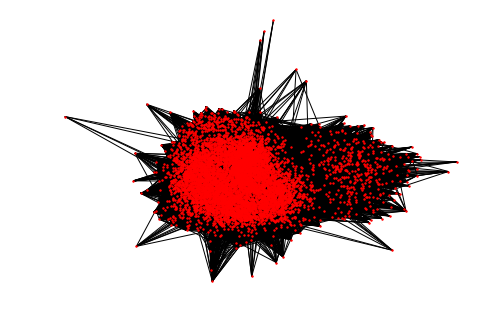

In [112]:
ppi_net_nx = nx.from_pandas_edgelist(ppi_net, 'p1', 'p2')
ppi_A = nd.array(nx.to_numpy_matrix(ppi_net_nx, nodelist=genelist_order))
fig = plt.figure()
nx.draw(ppi_net_nx, with_labels=False,node_size=2)
plt.show()

d:\python36\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


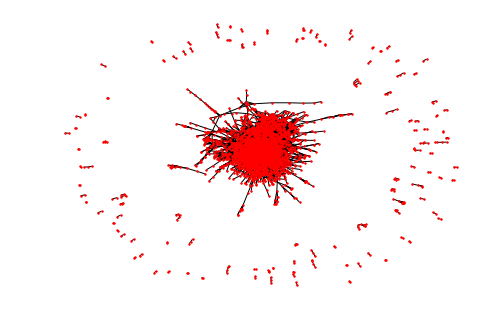

In [108]:
entry_net_nx = nx.from_pandas_edgelist(entry_net, 'id1', 'id2')
entry_A = nd.array(nx.to_numpy_matrix(entry_net_nx))
# fig = plt.figure()
# nx.draw(entry_net_nx, with_labels=False,node_size=2)
# plt.show()

d:\python36\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


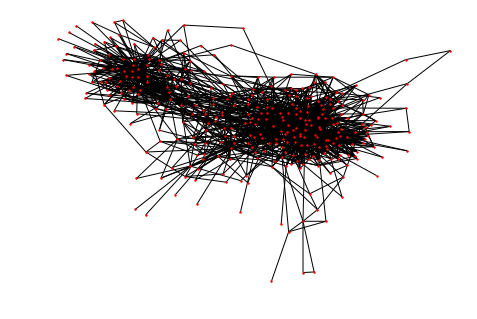

In [111]:
pathway_net = pd.read_csv('data/pathway2pathway.csv', sep=',', names=['p1', 'p2'])
pathway_net_nx = nx.from_pandas_edgelist(pathway_net, 'p1', 'p2')
pathway_A = nd.array(nx.to_numpy_matrix(pathway_net_nx))
fig = plt.figure()
nx.draw(pathway_net_nx, with_labels=False,node_size=2)
plt.show()

In [182]:
FeaturesTransformSet = load_gene_to_entry()

In [183]:
len(FeaturesTransformSet.entry_to_gene.keys())

5578

In [186]:
ppi_to_entry_features = FeaturesTransform(FeaturesTransformSet.entrylist, 
                                          FeaturesTransformSet.gene_to_index, 
                                          FeaturesTransformSet.entry_to_gene, 
                                          activation='relu')
ppi_to_entry_features.initialize()

In [190]:
entry_to_pathway_features = FeaturesTransform(FeaturesTransformSet.pathwaylist, 
                                              FeaturesTransformSet.entry_to_index, 
                                              FeaturesTransformSet.pathway_to_entry, 
                                              activation='relu')

In [200]:
num = len(FeaturesTransformSet.genelist_order)

x = nd.random.normal(0,1, shape=(num, 2))

In [201]:
ppi_to_entry_features(x)


[[0.         0.        ]
 [0.1105726  0.        ]
 [0.         0.        ]
 ...
 [0.03330735 0.        ]
 [0.         0.        ]
 [0.1916688  0.        ]]
<NDArray 5578x2 @cpu(0)>